## Imports and Constants

In [149]:
import os
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ["KMP_AFFINITY"] = "noverbose"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
tf.autograph.set_verbosity(3)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.

from sklearn.model_selection import train_test_split

# from utils import *

In [150]:
DATAPATH = 'dataset/'
MODELPATH = os.path.join(DATAPATH, 'humans/')
CLOTHINGPATH = os.path.join(DATAPATH, 'tops/')
SAVEDMODELPATH = os.path.join(DATAPATH, 'saved_models/')

## Load Data
### Load the humans

In [151]:
humans = pd.read_json(os.path.join(MODELPATH, 'model.json'))

In [152]:
humans

Alex  \
height                                              174.0   
bust                                                 81.0   
waist                                                64.0   
hips                                                 91.0   
url     https://birdsnest-images.imgix.net/system/imag...   

                                                   Amanda  \
height                                              178.0   
bust                                                 86.0   
waist                                                67.0   
hips                                                 89.0   
url     https://birdsnest-images.imgix.net/system/imag...   

                                                     Anna  \
height                                              175.0   
bust                                                 84.0   
waist                                                72.0   
hips                                                 98.0   
url     https://birdsnest-images.imgix.net/system/imag...   

                                               Anna Maria  \
height                                              179.0   
bust                                                 84.0   
waist                                                64.0   
hips                                                 90.0   
url     https://birdsnest-images.imgix.net/system/imag...   

                                                Anneliese  \
height                                              178.0   
bust                                                 84.0   
waist                                                64.0   
hips                                                 91.0   
url     https://images.prismic.io/birdsnest-blog/0f008...   

                                                     Bree  \
height                                              180.0   
bust                                                 99.0   
waist                                                72.0   
hips                                                107.0   
url     https://birdsnest-images.imgix.net/system/imag...   

                                                Charlotte  \
height                                              169.0   
bust                                                 88.0   
waist                                                67.0   
hips                                                 93.0   
url     https://birdsnest-images.imgix.net/system/imag...   

                                                  Chesska  \
height                                              173.0   
bust                                                 89.0   
waist                                                69.0   
hips                                                 94.0   
url     https://birdsnest-images.imgix.net/system/imag...   

                                                  Chelsea  \
height                                              177.0   
bust                                                 84.0   
waist                                                69.0   
hips                                                 96.0   
url     https://birdsnest-images.imgix.net/system/imag...   

                                               Clementine  ...  \
height                                              175.0  ...   
bust                                                 86.0  ...   
waist                                                65.0  ...   
hips                                                 91.0  ...   
url     https://birdsnest-images.imgix.net/system/imag...  ...   

                                                 Rosaline  \
height                                              175.0   
bust                                                 96.0   
waist                                                80.0   
hips                                                107.0   
url     https://birdsnest-images.imgix.net/syste

In [153]:
humans = humans.transpose()

In [154]:
humans

height   bust waist   hips  \
Alex        174.0   81.0  64.0   91.0   
Amanda      178.0   86.0  67.0   89.0   
Anna        175.0   84.0  72.0   98.0   
Anna Maria  179.0   84.0  64.0   90.0   
Anneliese   178.0   84.0  64.0   91.0   
...           ...    ...   ...    ...   
Stacey      169.0  101.0  80.0   98.0   
Stefania    172.0   97.0  73.0  103.0   
Summer      176.0   84.0  64.0   96.0   
Thais       178.0   86.5  61.0   92.5   
Tia         176.0  104.0  92.0  111.0   

                                                          url  
Alex        https://birdsnest-images.imgix.net/system/imag...  
Amanda      https://birdsnest-images.imgix.net/system/imag...  
Anna        https://birdsnest-images.imgix.net/system/imag...  
Anna Maria  https://birdsnest-images.imgix.net/system/imag...  
Anneliese   https://images.prismic.io/birdsnest-blog/0f008...  
...                                                       ...  
Stacey      https://birdsnest-images.imgix.net/system/imag...  
Stefania    https://birdsnest-images.imgix.net/system/imag...  
Summer      https://birdsnest-images.imgix.net/system/imag...  
Thais       https://birdsnest-images.imgix.net/system/imag...  
Tia         https://birdsnest-images.imgix.net/system/imag...  

[61 rows x 5 columns]

In [155]:
# save it as a csv file
# utils.save_file(humans, 'humans.csv', MODELPATH)
fp = os.path.join(MODELPATH, 'humans.csv')
humans.to_csv(fp)

### Load the tops
#### Load garment measurements and store in dataframe

In [156]:
# a function to do the intricate work
def parse_json(filepath):
    with open(filepath, 'r') as f:
        json_data = json.load(f)
    f.close()

    name = filepath.split('/')[-1].split('.')[0]
    
    try:
        keys = list(json_data.keys())
    except:
        return None


    data = []
    for size in keys:
        dims_data = {} # creating a dictionary for each clothing size, easier to work with
        dims_data['name'] = name
        dims_data['size'] = size

        for dim in json_data[size]:
            dims_data[dim["dimension_name"]] = dim["value"]

        data.append(dims_data)
    
    return data

In [157]:
# testing
path = 'dataset/tops/garment_measurement/avola-tunic#Sky_meta.txt'

# path = 'dataset/tops/garment_measurement/natural-textured-poncho#Deeprain_meta.txt'

parse_json(path)

In [158]:
dirpath = os.path.join(CLOTHINGPATH, 'garment_measurement')

data = []
count = 0
not_parsed = []

for file in os.listdir(dirpath):
    if file.endswith('.txt'):
        filepath = os.path.join(dirpath, file)

    data_ = parse_json(filepath)
    if data_ is None:
        count += 1
        not_parsed.append(filepath)
        continue
    
    for d in data_:
        data.append(d)

In [159]:
print(f"Number of files not parsed: {count}")

Number of files not parsed: 126


In [160]:
tops = pd.DataFrame(data)
tops = tops.sort_values(by=['name']).reset_index(drop=True)


In [161]:
tops

name size Length - shoulder to hem  \
0                   2-in-1-jumper#Navy_meta    M                  71-75cm   
1        2-in-1-layered-knit-top#Khaki_meta    M                  61-70cm   
2         2-in-1-layered-knit-top#Navy_meta    M                  61-70cm   
3     2-in-1-layered-knit-top#PalePink_meta    M                  61-70cm   
4       2-in-1-layered-top-1#NavyWhite_meta    M                     67cm   
...                                     ...  ...                      ...   
3823               yvette-blouse#Black_meta    8                      NaN   
3824               yvette-blouse#Black_meta   10                      NaN   
3825               yvette-blouse#Black_meta   16                      NaN   
3826               yvette-blouse#Black_meta   18                      NaN   
3827               zara-top#ZebraPrint_meta   12                  62-68cm   

     Sleeve Length - neck to hem    Hip   Bust  Waist Length - waist to hem  
0                           65cm  126cm  120cm  118cm                   NaN  
1                           56cm  138cm  114cm  124cm                   NaN  
2                           56cm  138cm  114cm  124cm                   NaN  
3                           56cm  138cm  114cm  124cm                   NaN  
4                           67cm  140cm  120cm    NaN                   NaN  
...                          ...    ...    ...    ...                   ...  
3823                        38cm  127cm    NaN   96cm                   NaN  
3824                        39cm  132cm    NaN  100cm                   NaN  
3825                        42cm  147cm    NaN  112cm                   NaN  
3826                        43cm  152cm    NaN  116cm                   NaN  
3827                        49cm  148cm  110cm  130cm                   NaN  

[3828 rows x 8 columns]

In [162]:
fp = os.path.join(CLOTHINGPATH, 'garment_meas_tops.csv')
tops.to_csv(fp)

In [163]:
tops.describe()

name  size Length - shoulder to hem  \
count                        3828  3828                     3737   
unique                        897    27                      177   
top     the-drape-tee-1#Navy_meta    12                     67cm   
freq                            9   610                      190   

       Sleeve Length - neck to hem    Hip   Bust  Waist Length - waist to hem  
count                         3067   2953   3702   2540                     6  
unique                         101    170    148    140                     6  
top                           70cm  110cm  120cm  110cm                  51cm  
freq                           157     79    117     91                     1

In [165]:
directory = os.path.join(CLOTHINGPATH, 'img_url')
tops_urls = []
tops_names = []

for file in os.listdir(directory):
    if file.endswith('.txt'):
        filepath = os.path.join(directory, file)
        tops_names.append(file.split('.')[0])

    with open(filepath, 'r') as f:
        urls = f.readlines()
        tops_urls.extend(urls)

tops_urls = [url.strip() for url in tops_urls]

### Display some sample images: Models, Tops, Onepieces

In [166]:
model_images_dir = os.path.join(MODELPATH, 'images')
tops_images_dir = os.path.join(CLOTHINGPATH, 'images')

In [167]:
model_images_dir

'dataset/humans/images'

In [168]:
model_images = [f for f in os.listdir(model_images_dir)]
sample_models = random.sample(model_images, 9)
tops_images = [f for f in os.listdir(tops_images_dir)]
sample_tops = random.sample(tops_images, 9)

In [169]:
sample_models

['Anna.png',
 'Shanaya.png',
 'Anna Maria.png',
 'Stacey.png',
 'Jira.png',
 'Nathalie_1.png',
 'Natalia.png',
 'Rosaline.png',
 'Monique.png']

In [170]:
def plotImages(images_arr, image_dir):
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))

    for i, image in enumerate(images_arr):
        img_path = os.path.join(image_dir, image)
        im = cv2.imread(img_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        axes[i//3, i%3].imshow(im)
        axes[i//3, i%3].axis('off')
        axes[i//3, i%3].set_title(image.split(".")[0])
    
    plt.tight_layout()
    plt.show()

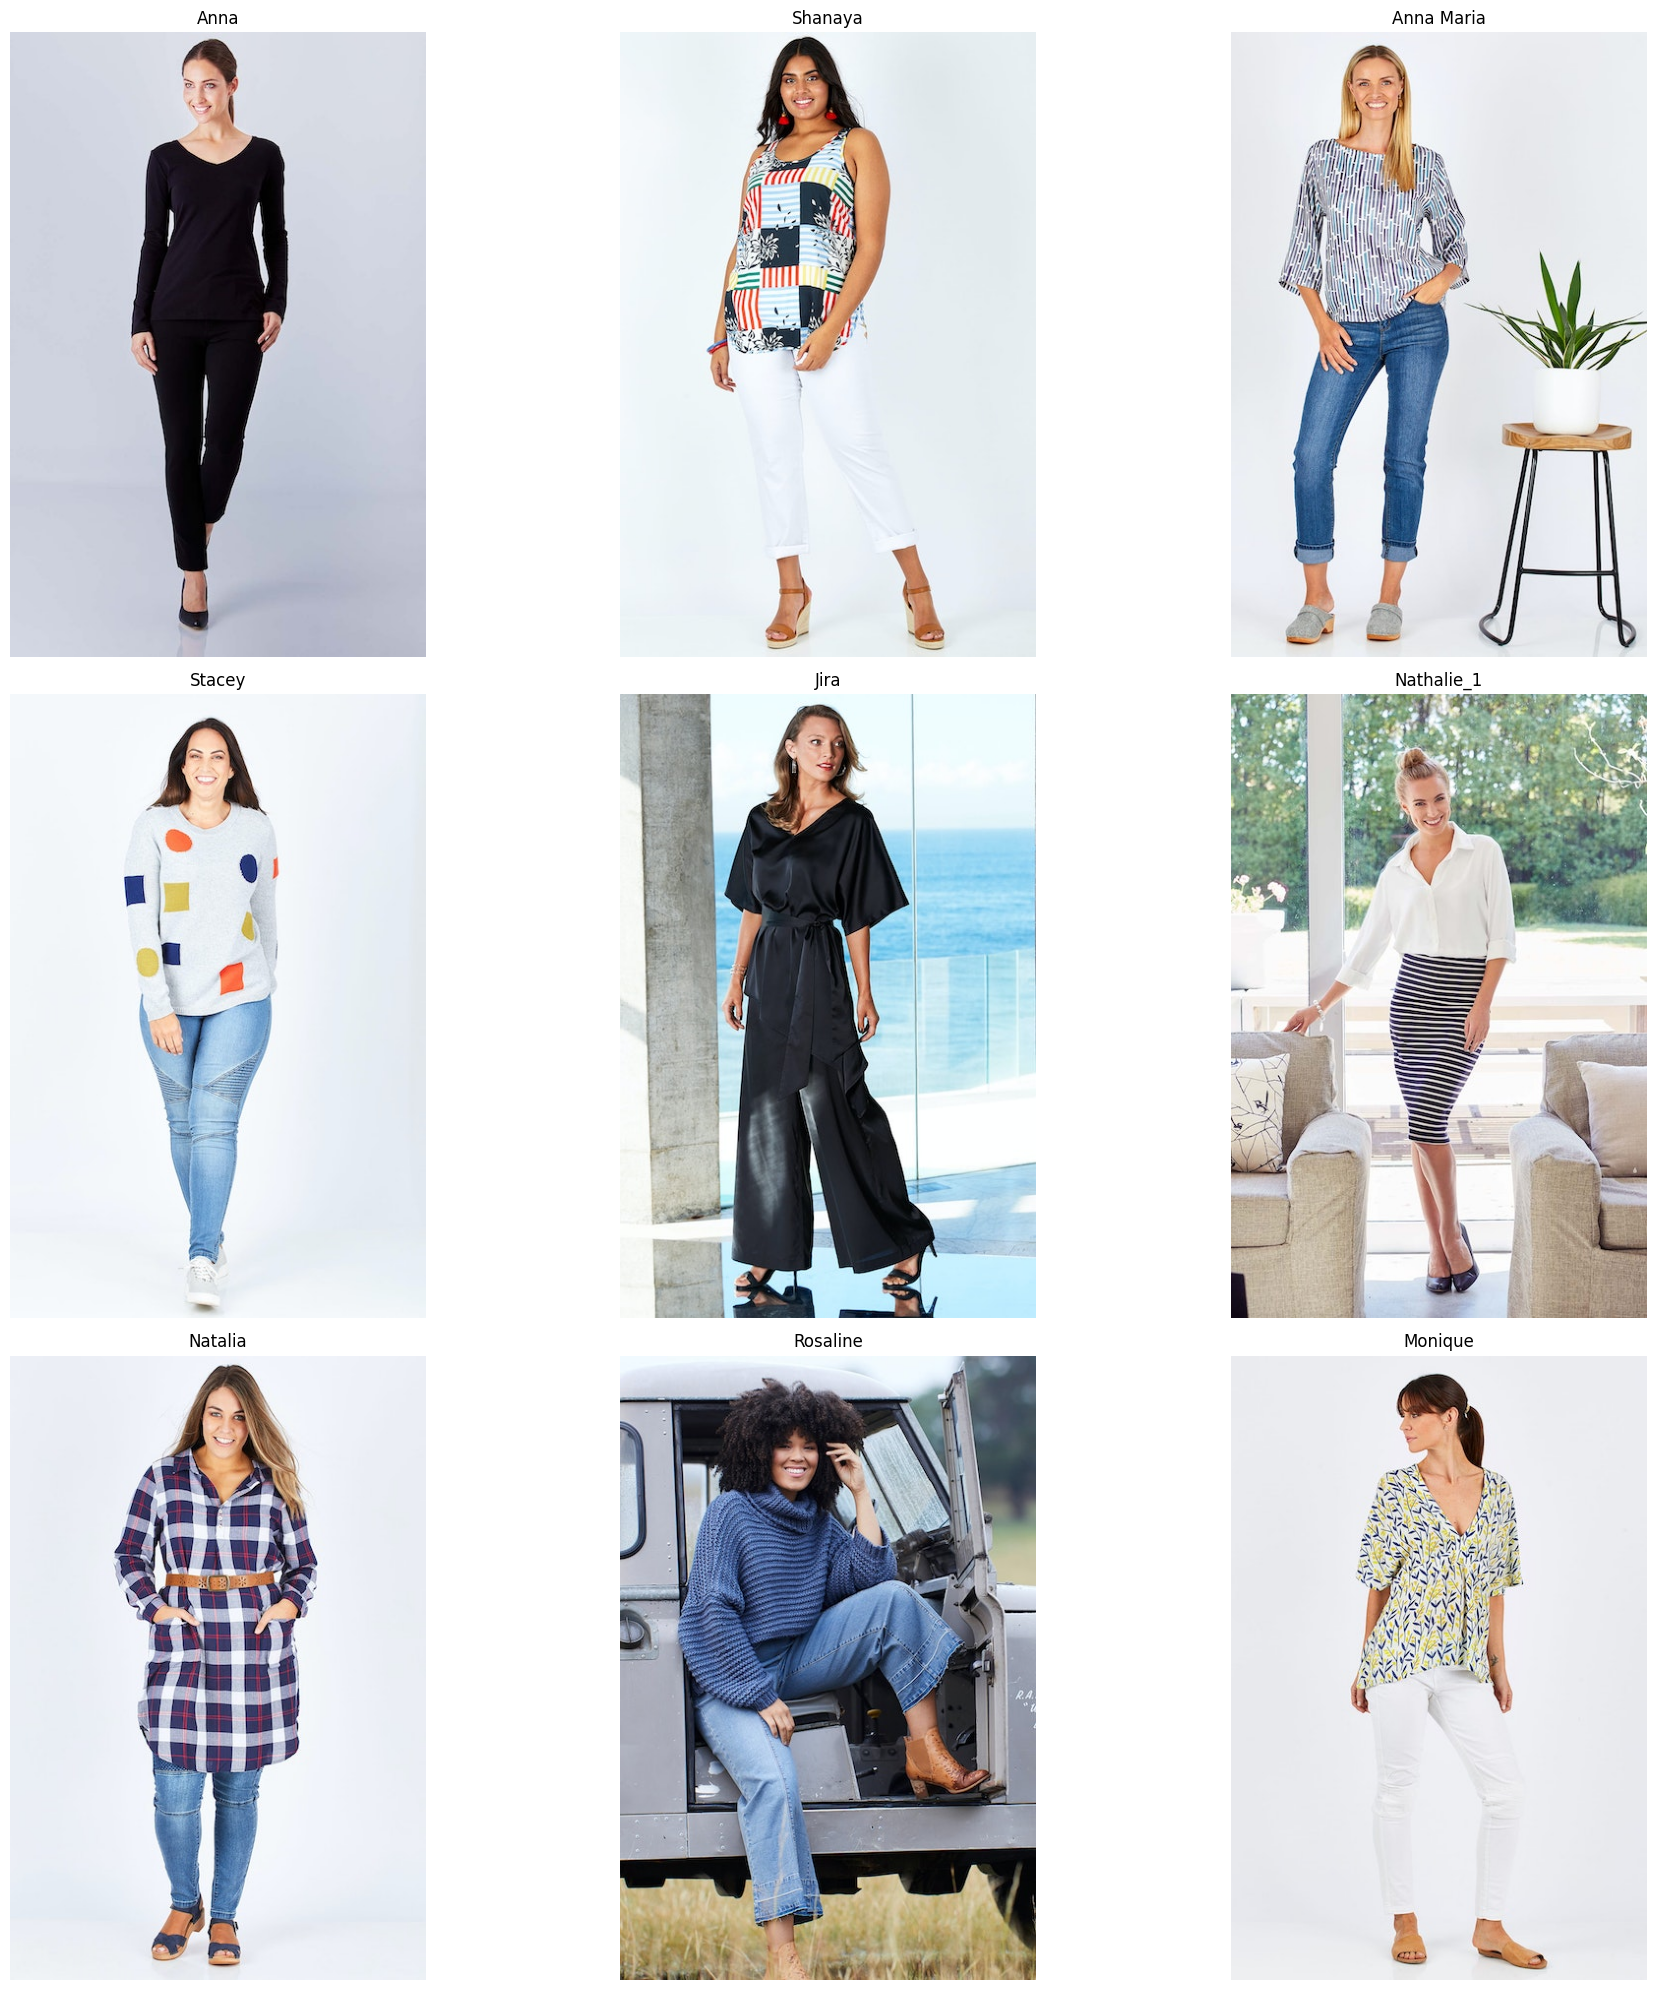

In [171]:
plotImages(sample_models, model_images_dir)

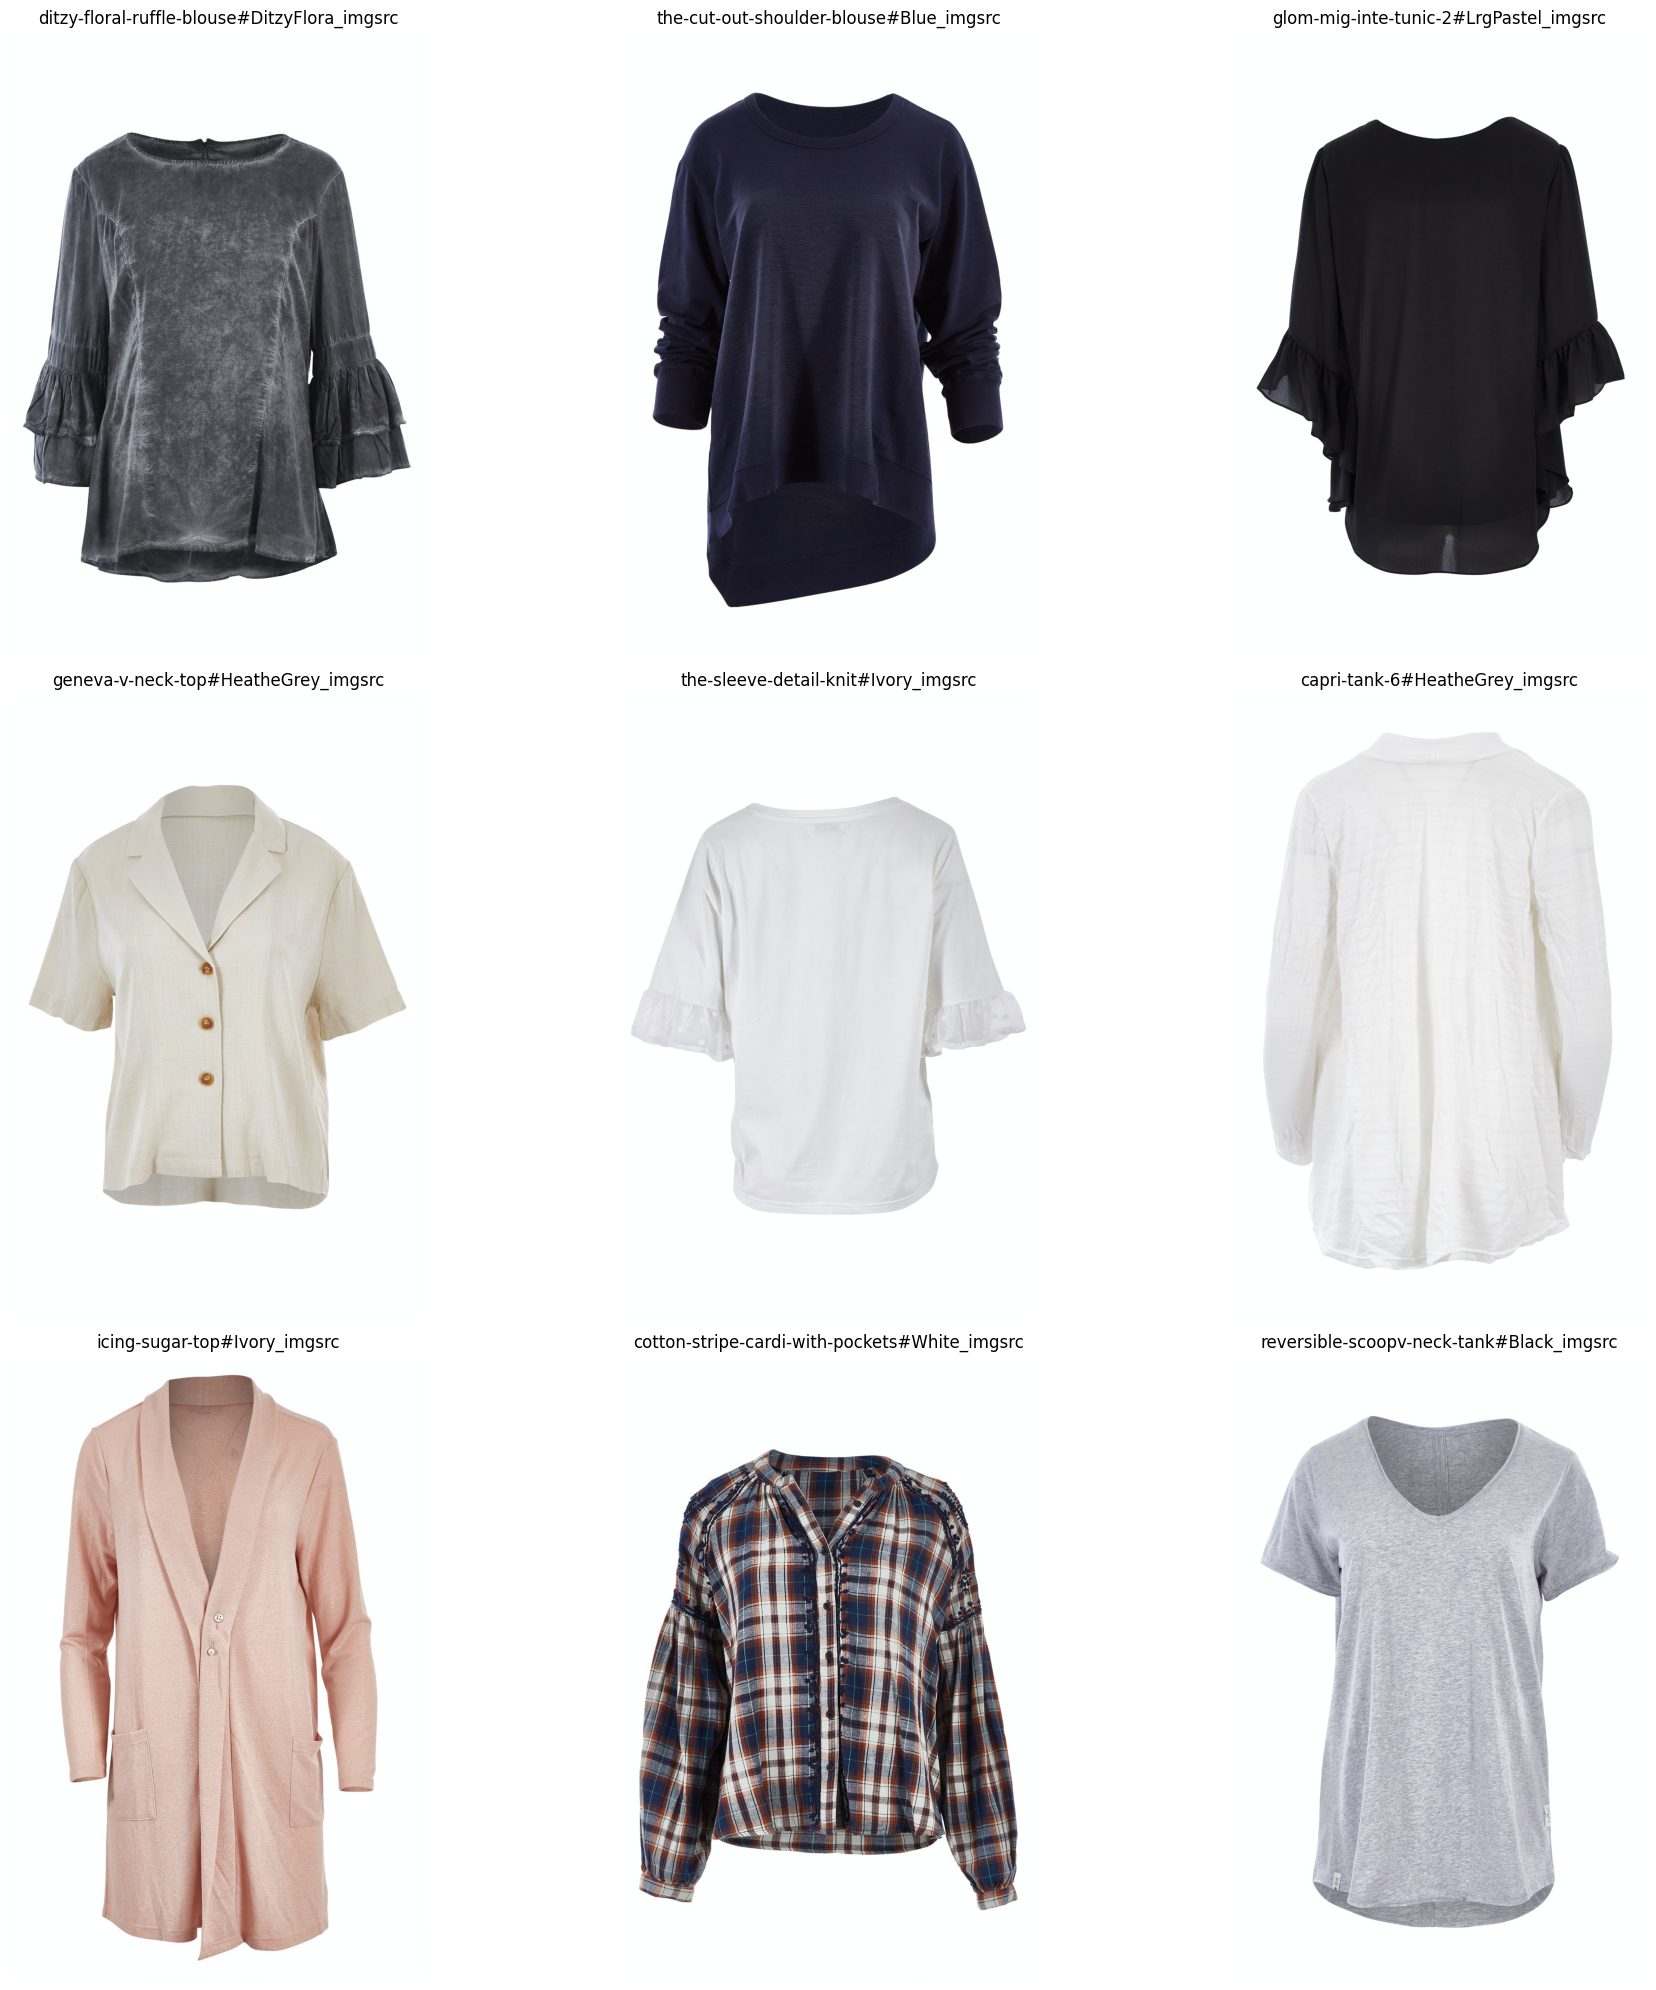

In [172]:
plotImages(sample_tops, tops_images_dir)

## Body Shape
### h_meas
#### Extract the vital statistics
- height
- bust
- waist
- hips

In [173]:
humans

height   bust waist   hips  \
Alex        174.0   81.0  64.0   91.0   
Amanda      178.0   86.0  67.0   89.0   
Anna        175.0   84.0  72.0   98.0   
Anna Maria  179.0   84.0  64.0   90.0   
Anneliese   178.0   84.0  64.0   91.0   
...           ...    ...   ...    ...   
Stacey      169.0  101.0  80.0   98.0   
Stefania    172.0   97.0  73.0  103.0   
Summer      176.0   84.0  64.0   96.0   
Thais       178.0   86.5  61.0   92.5   
Tia         176.0  104.0  92.0  111.0   

                                                          url  
Alex        https://birdsnest-images.imgix.net/system/imag...  
Amanda      https://birdsnest-images.imgix.net/system/imag...  
Anna        https://birdsnest-images.imgix.net/system/imag...  
Anna Maria  https://birdsnest-images.imgix.net/system/imag...  
Anneliese   https://images.prismic.io/birdsnest-blog/0f008...  
...                                                       ...  
Stacey      https://birdsnest-images.imgix.net/system/imag...  
Stefania    https://birdsnest-images.imgix.net/system/imag...  
Summer      https://birdsnest-images.imgix.net/system/imag...  
Thais       https://birdsnest-images.imgix.net/system/imag...  
Tia         https://birdsnest-images.imgix.net/system/imag...  

[61 rows x 5 columns]

In [174]:
humans.drop(columns=['url'], inplace=True)
humans

height   bust waist   hips
Alex        174.0   81.0  64.0   91.0
Amanda      178.0   86.0  67.0   89.0
Anna        175.0   84.0  72.0   98.0
Anna Maria  179.0   84.0  64.0   90.0
Anneliese   178.0   84.0  64.0   91.0
...           ...    ...   ...    ...
Stacey      169.0  101.0  80.0   98.0
Stefania    172.0   97.0  73.0  103.0
Summer      176.0   84.0  64.0   96.0
Thais       178.0   86.5  61.0   92.5
Tia         176.0  104.0  92.0  111.0

[61 rows x 4 columns]

In [175]:
humans.dropna(inplace=True)
humans.describe()

height  bust waist  hips
count      61    61    61    61
unique     16    24    28    29
top     178.0  86.0  64.0  89.0
freq       12    12    10     9

In [176]:
humans_dict = humans.to_dict('index')
humans_dict

{'Alex': {'height': '174.0', 'bust': '81.0', 'waist': '64.0', 'hips': '91.0'},
 'Amanda': {'height': '178.0',
  'bust': '86.0',
  'waist': '67.0',
  'hips': '89.0'},
 'Anna': {'height': '175.0', 'bust': '84.0', 'waist': '72.0', 'hips': '98.0'},
 'Anna Maria': {'height': '179.0',
  'bust': '84.0',
  'waist': '64.0',
  'hips': '90.0'},
 'Anneliese': {'height': '178.0',
  'bust': '84.0',
  'waist': '64.0',
  'hips': '91.0'},
 'Bree': {'height': '180.0', 'bust': '99.0', 'waist': '72.0', 'hips': '107.0'},
 'Charlotte': {'height': '169.0',
  'bust': '88.0',
  'waist': '67.0',
  'hips': '93.0'},
 'Chesska': {'height': '173.0',
  'bust': '89.0',
  'waist': '69.0',
  'hips': '94.0'},
 'Chelsea': {'height': '177.0',
  'bust': '84.0',
  'waist': '69.0',
  'hips': '96.0'},
 'Clementine': {'height': '175.0',
  'bust': '86.0',
  'waist': '65.0',
  'hips': '91.0'},
 'Denniel': {'height': '178.0',
  'bust': '94.0',
  'waist': '71.0',
  'hips': '91.0'},
 'Edith': {'height': '175.0',
  'bust': '84.0',
 

In [177]:
# combine statistics in a 4d array
humans_4d_stats = np.zeros((len(humans_dict), 4))
for i in enumerate(humans_dict):
    humans_4d_stats[i[0]] = np.array(list(humans_dict[i[1]].values()))

humans_4d_stats

array([[174. ,  81. ,  64. ,  91. ],
       [178. ,  86. ,  67. ,  89. ],
       [175. ,  84. ,  72. ,  98. ],
       [179. ,  84. ,  64. ,  90. ],
       [178. ,  84. ,  64. ,  91. ],
       [180. ,  99. ,  72. , 107. ],
       [169. ,  88. ,  67. ,  93. ],
       [173. ,  89. ,  69. ,  94. ],
       [177. ,  84. ,  69. ,  96. ],
       [175. ,  86. ,  65. ,  91. ],
       [178. ,  94. ,  71. ,  91. ],
       [175. ,  84. ,  66. , 101. ],
       [174. ,  81. ,  64. ,  91. ],
       [175. ,  83. ,  71. ,  99. ],
       [181. , 101. ,  83. , 115. ],
       [176. ,  86.5,  70. ,  91.5],
       [170. ,  81. ,  61. ,  89. ],
       [172. ,  86. ,  66. ,  99. ],
       [176.5,  86.5,  63.5,  89. ],
       [176. ,  99. ,  78. , 112. ],
       [174. ,  86. ,  64. ,  89. ],
       [175. ,  81. ,  66. ,  91. ],
       [180. , 104. ,  81. , 119. ],
       [174. ,  84. ,  63.5,  89. ],
       [178. ,  86.5,  61. ,  86.5],
       [177. , 101. ,  76. , 107. ],
       [180. , 112. ,  88. , 128. ],
 

### Standardization

In [178]:
shape = humans_4d_stats.shape
mean = humans_4d_stats.mean(axis=0)
std = humans_4d_stats.std(axis=0)

print("Shape: ", shape)
print("Mean: ", mean)
print("Standard deviation: ", std)

Shape:  (61, 4)
Mean:  [175.2704918   91.2295082   72.70491803  98.92622951]
Standard deviation:  [ 3.67710436  9.15243127 10.49604807 10.99360323]


In [179]:
# normalize
humans_4d_stats = (humans_4d_stats - mean) / std
humans_4d_stats

array([[-0.34551421, -1.11768206, -0.82935196, -0.72098559],
       [ 0.74229827, -0.57137913, -0.5435301 , -0.90290956],
       [-0.07356109, -0.7899003 , -0.06716033, -0.08425168],
       [ 1.01425139, -0.7899003 , -0.82935196, -0.81194758],
       [ 0.74229827, -0.7899003 , -0.82935196, -0.72098559],
       [ 1.28620451,  0.84900848, -0.06716033,  0.73440621],
       [-1.7052798 , -0.35285796, -0.5435301 , -0.53906161],
       [-0.61746733, -0.24359737, -0.35298219, -0.44809963],
       [ 0.47034515, -0.7899003 , -0.35298219, -0.26617565],
       [-0.07356109, -0.57137913, -0.73407801, -0.72098559],
       [ 0.74229827,  0.30270556, -0.16243428, -0.72098559],
       [-0.07356109, -0.7899003 , -0.63880405,  0.18863429],
       [-0.34551421, -1.11768206, -0.82935196, -0.72098559],
       [-0.07356109, -0.89916088, -0.16243428,  0.00671031],
       [ 1.55815762,  1.06752966,  0.98085317,  1.46210211],
       [ 0.19839203, -0.51674884, -0.25770824, -0.6755046 ],
       [-1.43332668, -1.

In [180]:
h_meas = tf.convert_to_tensor(humans_4d_stats, dtype=tf.float32)
h_meas

<tf.Tensor: shape=(61, 4), dtype=float32, numpy=
array([[-0.3455142 , -1.1176821 , -0.82935196, -0.7209856 ],
       [ 0.74229825, -0.5713791 , -0.5435301 , -0.9029096 ],
       [-0.07356109, -0.7899003 , -0.06716033, -0.08425168],
       [ 1.0142514 , -0.7899003 , -0.82935196, -0.8119476 ],
       [ 0.74229825, -0.7899003 , -0.82935196, -0.7209856 ],
       [ 1.2862045 ,  0.8490085 , -0.06716033,  0.73440623],
       [-1.7052798 , -0.35285795, -0.5435301 , -0.5390616 ],
       [-0.61746734, -0.24359737, -0.3529822 , -0.4480996 ],
       [ 0.47034514, -0.7899003 , -0.3529822 , -0.26617566],
       [-0.07356109, -0.5713791 , -0.734078  , -0.7209856 ],
       [ 0.74229825,  0.30270556, -0.16243428, -0.7209856 ],
       [-0.07356109, -0.7899003 , -0.6388041 ,  0.18863429],
       [-0.3455142 , -1.1176821 , -0.82935196, -0.7209856 ],
       [-0.07356109, -0.89916086, -0.16243428,  0.00671031],
       [ 1.5581577 ,  1.0675297 ,  0.98085314,  1.462102  ],
       [ 0.19839203, -0.51674885, -0

In [181]:
input_shape = h_meas.shape[1]

In [182]:
#defining the model, fcn, fc4, fc4
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 4)                 20        
                                                                 
 dense_19 (Dense)            (None, 4)                 20        
                                                                 
 dense_20 (Dense)            (None, 4)                 20        
                                                                 
Total params: 60 (240.00 Byte)
Trainable params: 60 (240.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [183]:
# compile the model
adam_opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.003, decay=0.01)
model.compile(optimizer=adam_opt, loss='mse')

In [184]:
def lr_sched(epoch):
    if epoch == 100:
        return 0.003 * 0.3
    elif epoch == 130:
        return 0.003 * 0.3 * 0.3
    else:
        return 0.003

In [185]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_sched)

In [186]:
# train the encoder
model.fit(h_meas, h_meas, epochs=180, callbacks=[lr_callback])

Epoch 1/180


2/2 [==============================] - 0s 4ms/step - loss: 0.9885 - lr: 0.0030
Epoch 2/180
2/2 [==============================] - 0s 2ms/step - loss: 0.9783 - lr: 0.0030
Epoch 3/180
2/2 [==============================] - 0s 3ms/step - loss: 0.9650 - lr: 0.0030
Epoch 4/180
2/2 [==============================] - 0s 2ms/step - loss: 0.9523 - lr: 0.0030
Epoch 5/180
2/2 [==============================] - 0s 2ms/step - loss: 0.9350 - lr: 0.0030
Epoch 6/180
2/2 [==============================] - 0s 2ms/step - loss: 0.9206 - lr: 0.0030
Epoch 7/180
2/2 [==============================] - 0s 2ms/step - loss: 0.9076 - lr: 0.0030
Epoch 8/180
2/2 [==============================] - 0s 2ms/step - loss: 0.8933 - lr: 0.0030
Epoch 9/180
2/2 [==============================] - 0s 2ms/step - loss: 0.8797 - lr: 0.0030
Epoch 10/180
2/2 [==============================] - 0s 2ms/step - loss: 0.8691 - lr: 0.0030
Epoch 11/180
2/2 [==============================] - 0s 2ms/step - loss: 0.8588 - lr: 0.0030
Epoch 12/

In [187]:
h_meas = model.predict(h_meas)

2/2 [==============================] - 0s 2ms/step


In [188]:
print(h_meas)

[[1.20686375e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.20686375e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.79584953e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.20686375e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.20686375e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.02670670e+00 1.23174727e+00 0.00000000e+00 7.24275589e-01]
 [0.00000000e+00 1.80415347e-01 0.00000000e+00 6.67497143e-02]
 [4.09104154e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.20686375e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.20686375e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.89110512e-01 2.08466023e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.20686375e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.04830217e+00 1.55497789e+00 0.00000000e+00 1.25258529e+00]
 [1.20686375e-01 0.00000000e+00 0.00000000e+00 0.000000

In [189]:
model.save(os.path.join(SAVEDMODELPATH, 'h_meas'))

### h_cnn

In [190]:
tops = "dataset/tops/images/"
onepiece = "dataset/onepiece/images/"

In [191]:
#define
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='avg'
)
model = tf.keras.models.Sequential([
    resnet,
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_21 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_22 (Dense)            (None, 256)               524544    
                                                                 
 dense_23 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 28310664 (108.00 MB)
Trainable params: 28257544 (107.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [192]:
adam_opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.003, decay=0.01)
model.compile(optimizer=adam_opt, loss='mse')

In [193]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_sched)

In [194]:
tops_image = [os.path.join(tops, f) for f in os.listdir(tops) if f.endswith('.png')]
onepiece_image = [os.path.join(onepiece, f) for f in os.listdir(onepiece) if f.endswith('.png')]

In [195]:
target_size = (224, 224)
batch_size = 32

In [196]:
tops = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in tops_image]
onepiece = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in onepiece_image]

In [197]:
tops = np.array(tops)
tops = tf.keras.applications.resnet50.preprocess_input(tops)

In [198]:
tops_embeddings = model.predict(tops)

33/33 [==============================] - 23s 676ms/step


In [199]:
tops_embeddings.shape

(1056, 8)

In [200]:
h_cnn = tops_embeddings

In [201]:
model.save(os.path.join(SAVEDMODELPATH, 'h_cnn'))

In [202]:
h_cnn

array([[0.03319234, 0.        , 0.5649117 , ..., 0.25416613, 0.25951502,
        0.        ],
       [0.        , 1.1360595 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10875317, 0.32550615, 0.39550903, ..., 0.50296926, 0.02954429,
        0.        ],
       ...,
       [0.        , 1.2242936 , 1.0059254 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.0988997 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.3197368 , 0.6004312 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

### h_attr

In [203]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/schecter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/schecter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [204]:
def generate_vocabulary(folder_path):
    vocabulary = set()
    stop_words = set(stopwords.words('english'))

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                description = file.read()
                tokens = word_tokenize(description.lower())
                tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
                vocabulary.update(tokens)

    return vocabulary

In [205]:
def bin_array(folder_path, vocabulary):
    binary_arrays = []
    i = 0
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            i += 1
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                description = file.read()
                tokens = word_tokenize(description.lower())
                binary_array = [1 if attr in tokens else 0 for attr in vocabulary]
                binary_arrays.append(binary_array)
    print(i)

    return binary_arrays

In [206]:
meta_descr = "dataset/tops/meta_descriptions/"
vocab = generate_vocabulary(meta_descr)
print(vocab.__len__())
print(vocab)
binary_arrays = bin_array(meta_descr, vocab)
print(len(binary_arrays))
binary_arrays = np.array(binary_arrays)
print(binary_arrays.shape)

841
{'fine', 'palm', 'wash', 'pull', 'two', 'approx', 'warmer', 'vintage', 'scoop', 'pleat', 'split', 'doll', 'ponte', 'mandarin', 'link', 'clasp', 'raw', 'panel', 'stripe', 'forward', 'arm', 'boxy', 'longline', 'oversize', 'collared', 'tier', 'animal', 'past', 'ball', 'right', 'open', 'textured', 'strech', 'jersy', 'twisted', 'peplum', 'music', 'tiered', 'pleating', 'shine', 'may', 'concealed', 'handmade', 'polyamide', 'wears', 'crossover', 'hot', 'kingdom', 'sized', 'fleck', 'hip', 'recommended', 'slub', 'cutout', 'additional', 'versatile', 'embellishments', 'point', 'bust', 'breast', 'elatane', 'jumper', 'closure', 'rose', 'dense', 'cm', 'wear', 'like', 'print', 'draped', 'lining', 'inverted', 'breathable', 'square', 'lo', 'fringing', 'ring', 'underlay', 'undone', 'softly', 'cu', 'scooped', 'piece', 'removable', 'plenty', 'fabric', 'marle', 'tight', 'wool', 'kaftan', 'fringe', 'measures', 'flair', 'fringed', 'girls', 'along', 'cupro', 'eye', 'require', 'three', 'styling', 'wrist', '

In [207]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(binary_arrays.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                53888     
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 8)                 264       
                                                                 
Total params: 56232 (219.66 KB)
Trainable params: 56232 (219.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [208]:
adam_opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.003, decay=0.01)
model.compile(optimizer=adam_opt, loss='mse')

In [209]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_sched)

In [210]:
h_attr = model.predict(binary_arrays)

 1/33 [..............................] - ETA: 1s

33/33 [==============================] - 0s 853us/step


In [211]:
h_attr.shape

(1056, 8)

In [212]:
h_attr

array([[0.08634806, 0.07756776, 0.00910046, ..., 0.05577949, 0.        ,
        0.        ],
       [0.        , 0.14909115, 0.19013265, ..., 0.06095929, 0.        ,
        0.        ],
       [0.06933613, 0.04887516, 0.1091869 , ..., 0.        , 0.        ,
        0.07886568],
       ...,
       [0.14368644, 0.3667748 , 0.02564952, ..., 0.        , 0.10589922,
        0.        ],
       [0.01063643, 0.11077152, 0.        , ..., 0.        , 0.        ,
        0.23598363],
       [0.03916332, 0.0631979 , 0.        , ..., 0.12605098, 0.01232849,
        0.        ]], dtype=float32)

In [213]:
model.save(os.path.join(SAVEDMODELPATH, 'h_attr'))

### h_body

In [235]:
h_images = [img for img in os.listdir("dataset/humans/images")]

In [236]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

In [237]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [238]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [247]:
# STEP 2: Create an PoseLandmarker object.
body_points = []

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

for img in h_images:
    image = mp.Image.create_from_file(os.path.join("dataset/humans/images", img))
    dect = detector.detect(image)
    temp = dect.pose_landmarks[0]
    
    body_points.append([[temp[11].x, temp[11].y, temp[11].z, temp[11].visibility],# left shoulder
                        [temp[12].x, temp[12].y, temp[12].z, temp[12].visibility],# right shoulder
                        [temp[13].x, temp[13].y, temp[13].z, temp[13].visibility],# left elbow
                        [temp[14].x, temp[14].y, temp[14].z, temp[14].visibility],# right elbow
                        [temp[23].x, temp[23].y, temp[23].z, temp[23].visibility],# left hip
                        [temp[24].x, temp[24].y, temp[24].z, temp[24].visibility],# right hip
                        [temp[25].x, temp[25].y, temp[25].z, temp[25].visibility],# left knee
                        [temp[26].x, temp[26].y, temp[26].z, temp[26].visibility]]# right knee)

body_points


libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

I0000 00:00:1702591088.314521  100387 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (se

[[[0.6507657766342163,
   0.20992174744606018,
   -0.19583913683891296,
   0.9999693632125854],
  [0.38974064588546753,
   0.21875670552253723,
   -0.32637882232666016,
   0.9999374151229858],
  [0.6847103238105774,
   0.3464975357055664,
   -0.012873601168394089,
   0.9545461535453796],
  [0.24927037954330444,
   0.30400362610816956,
   -0.3322998583316803,
   0.9630401134490967],
  [0.5918337106704712,
   0.4727972149848938,
   0.0698886588215828,
   0.9998621940612793],
  [0.43762657046318054,
   0.471868097782135,
   -0.07041363418102264,
   0.9998565912246704],
  [0.6208893656730652,
   0.688183069229126,
   0.07530511170625687,
   0.771706223487854],
  [0.4347362220287323,
   0.6778489947319031,
   -0.099479079246521,
   0.8304658532142639]],
 [[0.6712377071380615,
   0.19849979877471924,
   0.06928212195634842,
   0.9999414682388306],
  [0.4205969572067261,
   0.19682300090789795,
   0.157220259308815,
   0.9999277591705322],
  [0.715120255947113,
   0.338738352060318,
   -0.194

In [248]:
body_points = np.array(body_points)
body_points.shape

(61, 8, 4)

In [249]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(body_points.shape[1], body_points.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu')
])

In [250]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.003, decay=0.01)
model.compile(optimizer=opt, loss='mse')

In [251]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_sched)

In [252]:
model.fit(body_points, body_points, epochs=180, callbacks=[lr_callback])

Epoch 1/180


2/2 [==============================] - 0s 4ms/step - loss: 0.3270 - lr: 0.0030
Epoch 2/180
2/2 [==============================] - 0s 3ms/step - loss: 0.2813 - lr: 0.0030
Epoch 3/180
2/2 [==============================] - 0s 3ms/step - loss: 0.2262 - lr: 0.0030
Epoch 4/180
2/2 [==============================] - 0s 2ms/step - loss: 0.1777 - lr: 0.0030
Epoch 5/180
2/2 [==============================] - 0s 2ms/step - loss: 0.1388 - lr: 0.0030
Epoch 6/180
2/2 [==============================] - 0s 2ms/step - loss: 0.1097 - lr: 0.0030
Epoch 7/180
2/2 [==============================] - 0s 3ms/step - loss: 0.0928 - lr: 0.0030
Epoch 8/180
2/2 [==============================] - 0s 3ms/step - loss: 0.0855 - lr: 0.0030
Epoch 9/180
2/2 [==============================] - 0s 2ms/step - loss: 0.0849 - lr: 0.0030
Epoch 10/180
2/2 [==============================] - 0s 2ms/step - loss: 0.0864 - lr: 0.0030
Epoch 11/180
2/2 [==============================] - 0s 3ms/step - loss: 0.0872 - lr: 0.0030
Epoch 12/

In [253]:
h_body = model.predict(body_points)

2/2 [==============================] - 0s 2ms/step


In [257]:
h_body.shape

(61, 8, 4)

In [258]:
model.save(os.path.join(SAVEDMODELPATH, 'h_body'))